In [ ]:

import pandas as pd
from google.colab import drive

drive.mount('/content/drive')


file_path = '/content/drive/MyDrive/Superstore.xlsx'

df = pd.read_excel(file_path)  # Dosya adını ihtiyacınıza göre düzenleyin

# 3. Tarih sütununu datetime formatına dönüştürme
df['Order Date'] = pd.to_datetime(df['Order Date'])

# 4. Veri setindeki en son sipariş tarihini bulma
max_date = df['Order Date'].max()
print("Veri Setindeki En Son Sipariş Tarihi:", max_date)

# 5. RFM değerlerini hesaplayalama
rfm_data = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (max_date - x.max()).days,  # Recency
    'Order ID': 'nunique',                            # Frequency (toplam sipariş sayısı)
    'Sales': 'sum'                                    # Monetary (toplam harcama)
}).reset_index()

# 6. Sütunları yeniden adlandıralım
rfm_data.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# 7. İlk 5 veriyi görelim
print(rfm_data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Veri Setindeki En Son Sipariş Tarihi: 2014-12-31 00:00:00
  Customer ID  Recency  Frequency  Monetary
0    AA-10315      184          5  5563.560
1    AA-10375       19          9  1056.390
2    AA-10480      259          4  1790.512
3    AA-10645       55          6  5086.935
4    AB-10015      415          3   886.156


In [ ]:
# 1. RFM skorlarını hesaplama
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 5, labels=[5, 4, 3, 2, 1])  # Recency: Küçük daha iyi
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])  # Büyük daha iyi
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], 5, labels=[1, 2, 3, 4, 5])  # Büyük daha iyi

# 2. RFM Skorunu birleştir
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)

# 3. Segmentleri görme
print("RFM Skoru ile Oluşturulan Müşteri Segmentleri:")
print(rfm_data[['Customer ID', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head())


RFM Skoru ile Oluşturulan Müşteri Segmentleri:
  Customer ID R_Score F_Score M_Score RFM_Score
0    AA-10315       2       2       5       225
1    AA-10375       5       5       2       552
2    AA-10480       1       1       3       113
3    AA-10645       3       3       5       335
4    AB-10015       1       1       1       111


In [ ]:
# Segmentleri tanımlama fonksiyonu
def segment_rfm(row):
    if row['RFM_Score'] == '555':
        return 'En Değerli Müşteriler'
    elif row['R_Score'] == '5' and row['F_Score'] in ['4', '5']:
        return 'Sadık Müşteriler'
    elif row['R_Score'] in ['3', '4'] and row['F_Score'] in ['3', '4']:
        return 'Potansiyel Sadık Müşteriler'
    elif row['R_Score'] == '1' and row['F_Score'] == '1':
        return 'Uyuyan Müşteriler'
    elif row['R_Score'] == '1' and row['M_Score'] in ['4', '5']:
        return 'Kaybolan Müşteriler'
    elif row['R_Score'] in ['2', '3'] and row['F_Score'] in ['1', '2']:
        return 'Düşük Değerli Müşteriler'
    else:
        return 'Diğer'

# Segment sütununu ekleme
rfm_data['Segment'] = rfm_data.apply(segment_rfm, axis=1)

# Segmentleri görüntüleme
print("Müşteri Segmentleri:")
print(rfm_data[['Customer ID', 'RFM_Score', 'Segment']].head())

# Segment bazında müşteri sayısı
segment_counts = rfm_data['Segment'].value_counts()
print("\nSegment Bazında Müşteri Sayıları:")
print(segment_counts)


Müşteri Segmentleri:
  Customer ID RFM_Score Segment
0    AA-10315       225   Diğer
1    AA-10375       552   Diğer
2    AA-10480       113   Diğer
3    AA-10645       335   Diğer
4    AB-10015       111   Diğer

Segment Bazında Müşteri Sayıları:
Segment
Diğer                    771
En Değerli Müşteriler     22
Name: count, dtype: int64


In [ ]:
# Segment bazında toplam harcama (Monetary) ve müşteri sayısı
segment_analysis = rfm_data.groupby('Segment').agg({
    'Monetary': 'sum',
    'Customer ID': 'count'
}).rename(columns={'Monetary': 'Toplam Harcama', 'Customer ID': 'Müşteri Sayısı'})

# Analizi görüntüleme
print("Segment Bazında Satış Performansı:")
print(segment_analysis)


Segment Bazında Satış Performansı:
                       Toplam Harcama  Müşteri Sayısı
Segment                                              
Diğer                    2.158166e+06             771
En Değerli Müşteriler    1.390351e+05              22


In [ ]:
# Müşteri başına ortalama harcama
segment_analysis['Müşteri Başı Ortalama Harcama'] = segment_analysis['Toplam Harcama'] / segment_analysis['Müşteri Sayısı']

print("Segment Bazında Müşteri Başı Ortalama Harcama:")
print(segment_analysis)


Segment Bazında Müşteri Başı Ortalama Harcama:
                       Toplam Harcama  Müşteri Sayısı  \
Segment                                                 
Diğer                    2.158166e+06             771   
En Değerli Müşteriler    1.390351e+05              22   

                       Müşteri Başı Ortalama Harcama  
Segment                                               
Diğer                                    2799.177436  
En Değerli Müşteriler                    6319.775309  


<ipython-input-7-e0d99f458a43>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample('M', on='Order Date')['Sales'].sum()


Order Date
2011-01-31    13946.229
2011-02-28     4810.558
2011-03-31    55691.009
2011-04-30    28295.345
2011-05-31    23648.287
Freq: ME, Name: Sales, dtype: float64


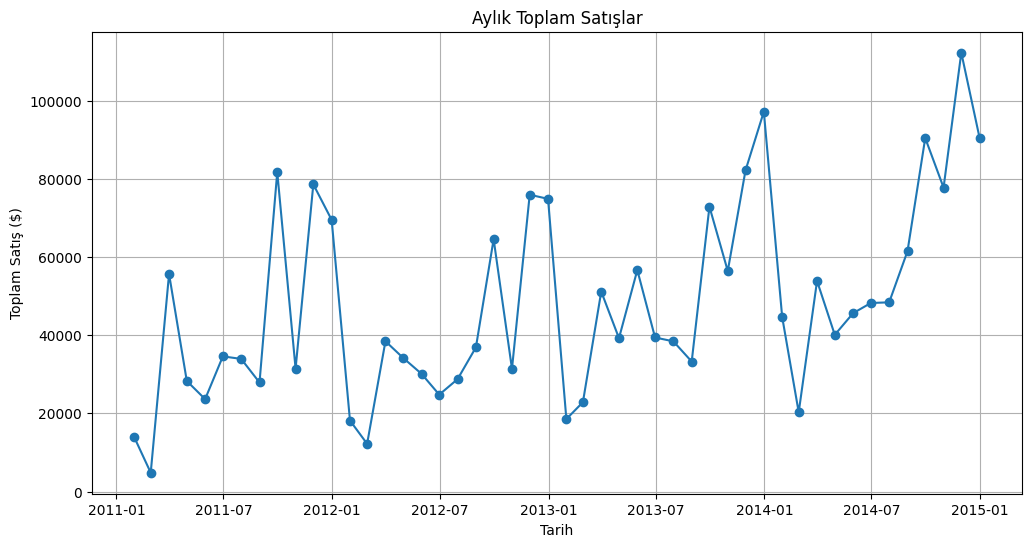

In [ ]:
# Tarihe göre sıralama
df = df.sort_values(by='Order Date')

# Aylık bazda toplam satışların hesaplanması
monthly_sales = df.resample('M', on='Order Date')['Sales'].sum()

# İlk 5 veriyi görme
print(monthly_sales.head())

# Zaman serisi grafiği
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-')
plt.title('Aylık Toplam Satışlar')
plt.xlabel('Tarih')
plt.ylabel('Toplam Satış ($)')
plt.grid()
plt.show()


Gelecek 6 Aylık Tahmin:
2015-01-31    77903.873558
2015-02-28    74627.836153
2015-03-31    73774.073210
2015-04-30    73551.575396
2015-05-31    73493.590591
2015-06-30    73478.479262
Freq: ME, Name: predicted_mean, dtype: float64


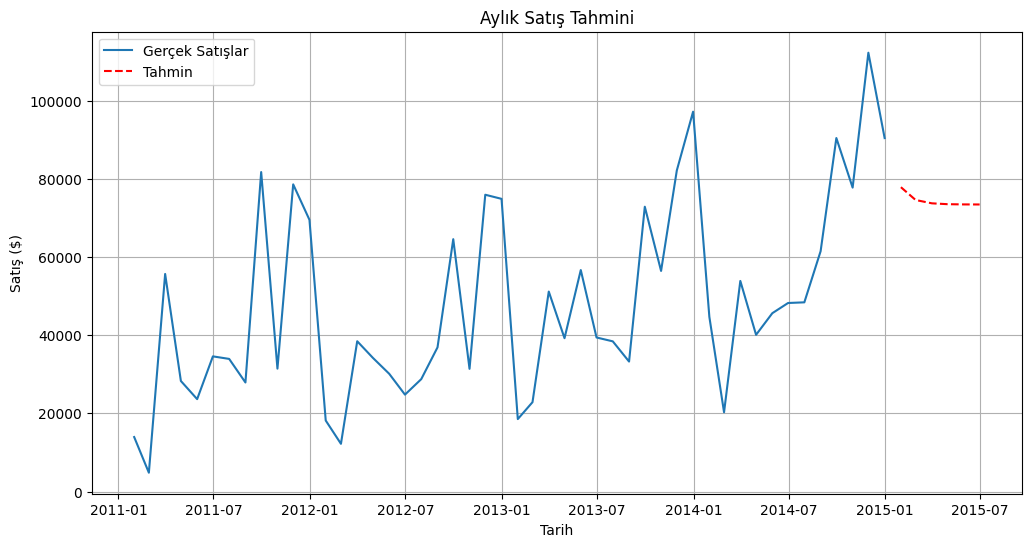

In [ ]:
# Zaman serisi modelleme için kütüphane
from statsmodels.tsa.arima.model import ARIMA

# ARIMA modelinin oluşturulması (örnek p=1, d=1, q=1)
model = ARIMA(monthly_sales, order=(1, 1, 1))  # ARIMA parametrelerini optimize etme
model_fit = model.fit()

# Gelecek 6 ay için tahmin
forecast = model_fit.forecast(steps=6)
print("Gelecek 6 Aylık Tahmin:")
print(forecast)

# Tahminleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, label='Gerçek Satışlar')
plt.plot(forecast.index, forecast.values, color='red', linestyle='--', label='Tahmin')
plt.title('Aylık Satış Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Satış ($)')
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1077.239, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1095.659, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1073.862, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1075.397, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1093.843, Time=0.01 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1089.418, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1075.748, Time=0.16 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1075.857, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1078.923, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1077.278, Time=0.34 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1079.678, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1070.676, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1086.744, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1072.497, Time=0.22 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1072.645, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=1076.262, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=1074.059, Time=0.44 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=1073.162, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1073.536, Time=0.17 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1073.651, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=2.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[12]             : AIC=1068.893, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=1085.666, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12]             : AIC=1070.585, Time=0.73 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[12]             : AIC=1070.635, Time=0.77 sec
 ARIMA(2,1,0)(0,0,1)[12]             : AIC=1074.879, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12]             : AIC=1072.503, Time=0.93 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12]             : AIC=1071.892, Time=0.92 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,0)[12]             : AIC=1071.359, Time=0.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12]             : AIC=1070.355, Time=0.27 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=1070.157, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[12]             : AIC=1072.303, Time=0.30 sec

Best model:  ARIMA(2,1,0)(1,0,0)[12]          
Total fit time: 9.592 seconds
Ortalama Mutlak Hata (MAE): 20511.51431482227
Kök Ortalama Kare Hatası (RMSE): 23435.025838763522


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


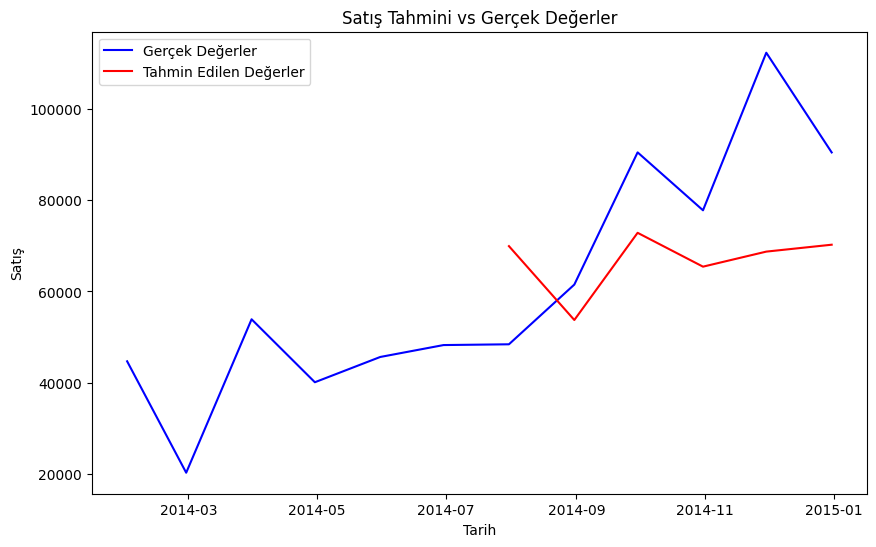

In [ ]:
!pip install pmdarima

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Gerçek değerler ile tahmin değerlerini karşılaştırmak için test verisi ekleme
y_true = monthly_sales[-6:]  # Son 6 ayı gerçek veri olarak kabul etme

# auto_arima modelini oluşturuyoruz ve en iyi parametreleri buluyoruz
stepwise_model = auto_arima(monthly_sales, seasonal=True, m=12, trace=True)

# Modelin tahminlerini alma
y_pred = stepwise_model.predict(n_periods=6)  # Sonraki 6 ay için tahmin

# Hata hesaplama
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Ortalama Mutlak Hata (MAE): {mae}")
print(f"Kök Ortalama Kare Hatası (RMSE): {rmse}")

# Gerçek ve tahmin edilen verileri görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index[-12:], monthly_sales[-12:], label='Gerçek Değerler', color='blue')  # Son 12 ay
plt.plot(monthly_sales.index[-6:], y_pred, label='Tahmin Edilen Değerler', color='red')  # Son 6 ayın tahmini
plt.legend()
plt.title('Satış Tahmini vs Gerçek Değerler')
plt.xlabel('Tarih')
plt.ylabel('Satış')
plt.show()

